In [5]:
import gooseberry as gs 

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib.patches import Ellipse
import numpy as np 

import jax 
import jax.numpy as jnp
from functools import partial 

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

In [70]:
"""
randomly initialised balanced weights of dimensions in_dim, 
hidden_dim, out_dim and balance coefficient c
""" 


def balanced_weights(in_dim, hidden_dim, out_dim, c):

    #random number bigger than c:
    a = np.random.exponential(scale = 5) + c 
    b = np.sqrt(a*a - c)

    #TODO: not sure which dimension, doesnt work for hidden_dim > min(out_dim, in_dim)
    S_1 = a * np.eye(max(hidden_dim, in_dim))[:hidden_dim, :in_dim]
    S_2 = b * np.eye(max(out_dim, hidden_dim))[:out_dim, :hidden_dim] 

    random_matrix_one = np.random.rand(hidden_dim, hidden_dim)
    random_matrix_two = np.random.rand(in_dim, in_dim)
    random_matrix_three = np.random.rand(out_dim, out_dim)

    q_one, _ = np.linalg.qr(random_matrix_one)
    q_two, _ = np.linalg.qr(random_matrix_two)
    q_three, _ = np.linalg.qr(random_matrix_three)

    U_1 = q_one 
    V_2 = q_one 
    V_1 = q_two
    U_2 = q_three

    W1 = U_1 @ S_1 @ (V_1.T)
    W2 = U_2 @ S_2 @ (V_2.T)

    return W1, W2 



In [60]:
def check_balance(w1, w2):
    return w1 @ w1.T - w2.T @ w2 

In [107]:
w1, w2 = balanced_weights(14, 14, 14, 5)

check_balance(w1, w2)

array([[ 5.00000000e+00,  1.80089883e-15,  5.64546627e-16,
         2.00029871e-15, -2.13549663e-16, -7.52625464e-16,
        -1.14449463e-14,  4.35187177e-15, -1.79663690e-14,
        -1.30172139e-14,  7.28404822e-15,  2.93981946e-14,
         5.94803701e-16, -2.79037029e-14],
       [ 1.80089883e-15,  5.00000000e+00, -1.82892042e-15,
         1.22799908e-14,  5.51880362e-15, -3.48643885e-15,
         7.08059086e-15,  5.78634336e-15,  2.10497509e-14,
         6.36644807e-15, -2.51154781e-15, -5.13163315e-15,
        -1.13548990e-14, -7.25385909e-16],
       [ 5.64546627e-16, -1.82892042e-15,  5.00000000e+00,
         8.51563713e-15,  1.74902427e-14, -2.44616618e-17,
        -1.05618638e-14, -2.05222006e-14, -1.63674644e-14,
         6.72511536e-15,  1.13486673e-14,  5.75651502e-15,
        -9.24661684e-15, -6.98654524e-15],
       [ 2.00029871e-15,  1.22799908e-14,  8.51563713e-15,
         5.00000000e+00, -9.27347478e-15, -1.89830927e-14,
         1.94651675e-15,  1.36677792e-14,  1.

Task: Plot representations for balanced weights when task is learned

In [73]:
bc = BlindColours()
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()

In [74]:
def logs(params, X, Y, out_dim):
    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    w2w1 = w2 @ w1
    w1w1 = w1.T @ w1
    w2w2 = w2 @ w2.T
    return w2w1, w1w1, w2w2

logs = jax.jit(logs)

In [110]:
np.random.seed(1)

in_dim = 8
hidden_dim = 8
out_dim = 8
cs = [0, 0.5, 2, 10]
learning_rate = 0.05
training_steps = 2000

training_data, _, _ = gs.datasets.Hierarchy(False, True)

network_functions = []
w1w1s = []
w2w2s = []
lossess = []


for c in cs:
    w1_init, w2_init = balanced_weights(in_dim, hidden_dim, out_dim, c)
    w1_init, w2_init = gs.init.FromFixedValue(w1_init), gs.init.FromFixedValue(w2_init)

    network_function = []
    w1w1 = []
    w2w2 = []
    losses = []

    X, Y = training_data(None)

    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss_fnct = gs.MeanSquaredError()

    mlp = gs.Network([
        gs.Linear(hidden_dim, bias = False, weight_init=w1_init),
        gs.Linear(out_dim, bias = False, weight_init=w2_init)
    ])

    trainer = gs.Trainer(task, mlp, loss_fnct, optimiser)
    state, params = gs.assemble(1)

    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    network_function.append(w2 @ w1)
    w1w1.append(w1.T @ w1)
    w2w2.append(w2 @ w2.T)

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        w2w1_, w1w1_, w2w2_ = logs(params, X, Y, out_dim)
        network_function.append(w2w1_)
        w1w1.append(w1w1_)
        w2w2.append(w2w2_)
        losses.append(1./8. * loss)
    
    network_functions.append(network_function)
    w1w1s.append(w1w1)
    w2w2s.append(w2w2)
    losses.append(losses)



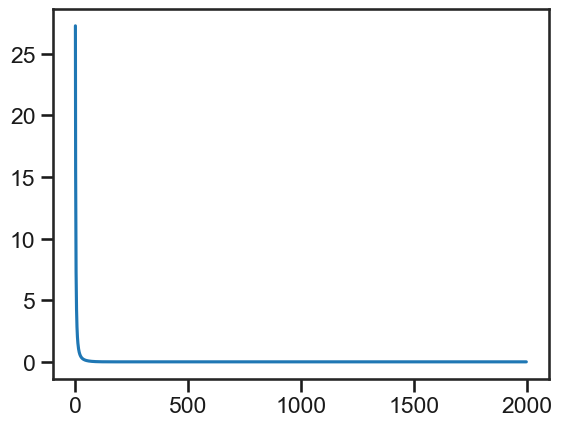

In [92]:
plt.plot(losses)

In [94]:
def arange_svd(Y, u, vt):
    sort = np.sign(np.abs(np.round(Y.T @ vt.T)))
    idxs = np.where(sort == 1)[1]
    u = u @ sort.T
    sgn = np.diag(np.sign(np.sum(u, axis=0)))
    u = sgn.T @ u
    vt = sort @ vt
    vt = sgn @ vt
    return u, vt

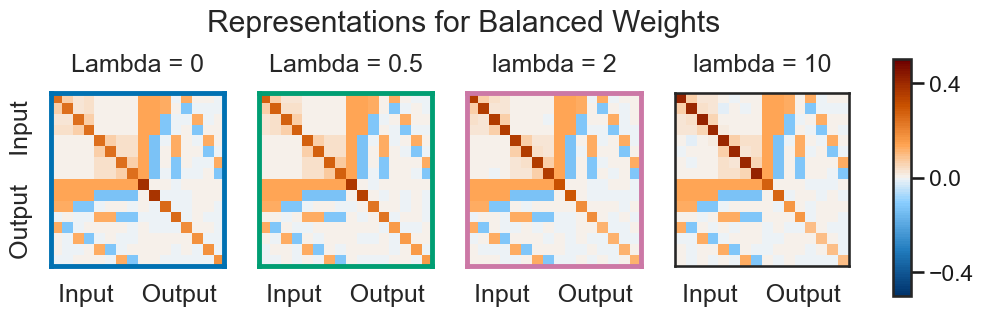

In [111]:
labels = ["Lambda = 0", "Lambda = 0.5", "lambda = 2", "lambda = 10"]



fig, axs = plt.subplots(1, 4, figsize=(11, 3.5), sharex=True, sharey=True)
fig.suptitle("Representations for Balanced Weights")
for i, label in enumerate(labels):
    qqt = np.vstack([
        np.hstack([w1w1s[i][-1], network_functions[i][-1].T]),
        np.hstack([network_functions[i][-1], w2w2s[i][-1]])
    ])
    vals = axs[i].matshow(1./8. * qqt, cmap=div_cmap, vmin=-1./8. * 4, vmax=1./8. * 4)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(label, pad=15.)

for ax in axs:
    ax.set_xlabel("Input    Output")
axs[0].set_ylabel("Output    Input")
    
for ax, c in zip(axs, colours):
    for spine in ax.spines.values():
        spine.set_edgecolor(c)
        spine.set_linewidth(3.5)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.89, 0.1625, 0.017, 0.675])
cbar = fig.colorbar(vals, cax=cbar_ax)
cbar.ax.set_yticks([-0.4, 0., 0.4])
fig.savefig("./figures/figure-3_c-d-e.svg")